# [Interval Competition: House Prices](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price)

## Описание
Как уже упоминалось, в регрессионном анализе нередко фокусируются на так называемых точечных прогнозах (отражающих центральную тенденцию). Однако в этом соревновании нас интересует создание интервала прогнозирования (отражающего дисперсию).

Наша задача — создать регрессионную модель с самыми узкими (наиболее «эффективными») общими интервалами прогнозирования

## Оценка
Мы оценим общую эффективность нашей модели, используя среднее значение показателя интервала Винклера, которое для отдельного интервала определяется следующим образом:

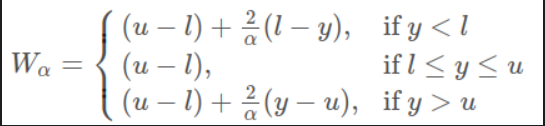

где 
 это истинная ценность, 
 это верхний предел прогнозного интервала, 
 это нижний предел прогнозного интервала, и 
 Это (100-процентное покрытие)/100.

Покрытие
В этом соревновании целью является номинальное предельное покрытие в 90% (т.е. 
). То есть 90% интервалов прогнозирования содержат истинное значение (y_true).

________________________________________________________________________________________________________________________________________________________

# Ипопрт необходимых библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

# Data Engineering

## Удалим столбцы в которых есть пропущенные значения и назначение индексируемого столбца

In [160]:
def clearing_missing_values(df):
    print("Начало работы функции clearing_missing_values")
    kol_mistakes = df.isnull().sum()
    columns_with_mistakes = df.isnull().sum()[kol_mistakes > 0]
    drop_feature = columns_with_mistakes.index.tolist()
    df = df.drop(columns=drop_feature)

    assert df['id'].is_unique 
    df = df.set_index('id')
    return df


## Из числовых признаков формируем пары для выявления нелинейных зависимостей

In [161]:
def create_peirs_of_feature(df):
    print("Начало работы функции create_peirs_of_feature")

    from itertools import combinations

    important_nums = list(set([
        'area', 'sqft', 'land_val', 'imp_val', 'grade', 'beds',
        'bath_full', 'sqft_lot', 'sqft_1', 'sqft_fbsmt',
        'garb_sqft', 'gara_sqft'
    ]))
    
    

    for f1, f2 in combinations(important_nums, 2):
        col_name = f"{f1}_x_{f2}"
        df[col_name] = df[f1] * df[f2]

    return df

## Создадим данные связанные со временем, для выявления временных зависимостей

In [162]:
def add_date_features(df):
    print("Начало работы функции add_date_features")
    df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')

    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month

    df['month_sin'] = np.sin(2 * np.pi * df['sale_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['sale_month'] / 12)

    df['house_age'] = df['sale_year'] - df['year_built']

    df['renovated'] = (df['year_reno'] > 0).astype(int)

    df['years_since_renovation'] = np.where(
        df['year_reno'] > 0,
        df['sale_year'] - df['year_reno'],
        df['house_age']  
    )
    
    df.drop(columns=['sale_date'], inplace=True)

    return df

## Добавим еще различные полезные фичи

In [163]:
def new_features(df):
    print("Начало работы функции new_features")
    df['total_bath'] = df['bath_full'] + 0.75 * df['bath_3qtr'] + 0.5 * df['bath_half']
    df['total_view'] = df[[c for c in df.columns if 'view_' in c]].sum(axis=1)

    df['lot_utilization'] = df['sqft'] / df['sqft_lot']
    df['garage_ratio'] = df['gara_sqft'] / (df['sqft'] + 1e-3)
    df['bath_bed_ratio'] = df['total_bath'] / (df['beds'] + 1e-3)

    df['structure_share'] = df['imp_val'] / (df['imp_val'] + df['land_val'] + 1e-3)

    df['has_basement'] = (df['sqft_fbsmt'] > 0).astype(int)
    df['has_garage'] = (df['gara_sqft'] > 0).astype(int)
    df['was_renovated'] = (df['year_reno'] > 0).astype(int)
    df['has_view'] = (df['total_view'] > 0).astype(int)

    df['condition_grade'] = df['condition'] * df['grade']

    df['total_area'] = df['sqft'] + df['sqft_fbsmt'] + df['gara_sqft']

    return df


## Логарифмирование больших значений

In [164]:
def log_transform_features(df, flag_train = False):
    print("Начало работы функции log_transform_features")
    if flag_train:
        log_candidates = [
            'grade_x_land_val', 'grade_x_sqft_lot', 'grade_x_sqft', 'grade_x_sqft_fbsmt', 'grade_x_gara_sqft',
            'grade_x_imp_val', 'beds_x_land_val', 'beds_x_sqft_lot', 'beds_x_sqft', 'beds_x_sqft_fbsmt',
            'beds_x_gara_sqft', 'beds_x_imp_val', 'garb_sqft_x_land_val', 'garb_sqft_x_sqft_lot',
            'garb_sqft_x_sqft', 'garb_sqft_x_sqft_fbsmt', 'garb_sqft_x_gara_sqft', 'garb_sqft_x_imp_val',
            'sqft_1_x_land_val', 'sqft_1_x_sqft_lot', 'sqft_1_x_sqft', 'sqft_1_x_sqft_fbsmt', 'sqft_1_x_gara_sqft',
            'sqft_1_x_imp_val', 'area_x_land_val', 'area_x_sqft_lot', 'area_x_sqft', 'area_x_sqft_fbsmt',
            'area_x_gara_sqft', 'area_x_imp_val', 'land_val_x_sqft_lot', 'land_val_x_sqft',
            'land_val_x_sqft_fbsmt', 'land_val_x_gara_sqft', 'land_val_x_imp_val', 'sqft_lot_x_sqft',
            'sqft_lot_x_sqft_fbsmt', 'sqft_lot_x_gara_sqft', 'sqft_lot_x_imp_val', 'bath_full_x_sqft',
            'bath_full_x_sqft_fbsmt', 'bath_full_x_gara_sqft', 'bath_full_x_imp_val', 'sqft_x_sqft_fbsmt',
            'sqft_x_gara_sqft', 'sqft_x_imp_val', 'sqft_fbsmt_x_gara_sqft', 'sqft_fbsmt_x_imp_val',
            'gara_sqft_x_imp_val', 'sale_price', 'land_val', 'imp_val', 'sqft_lot',
            'price_per_sqft', 'total_area'
        ]
    else:
        log_candidates = [
            'grade_x_land_val', 'grade_x_sqft_lot', 'grade_x_sqft', 'grade_x_sqft_fbsmt', 'grade_x_gara_sqft',
            'grade_x_imp_val', 'beds_x_land_val', 'beds_x_sqft_lot', 'beds_x_sqft', 'beds_x_sqft_fbsmt',
            'beds_x_gara_sqft', 'beds_x_imp_val', 'garb_sqft_x_land_val', 'garb_sqft_x_sqft_lot',
            'garb_sqft_x_sqft', 'garb_sqft_x_sqft_fbsmt', 'garb_sqft_x_gara_sqft', 'garb_sqft_x_imp_val',
            'sqft_1_x_land_val', 'sqft_1_x_sqft_lot', 'sqft_1_x_sqft', 'sqft_1_x_sqft_fbsmt', 'sqft_1_x_gara_sqft',
            'sqft_1_x_imp_val', 'area_x_land_val', 'area_x_sqft_lot', 'area_x_sqft', 'area_x_sqft_fbsmt',
            'area_x_gara_sqft', 'area_x_imp_val', 'land_val_x_sqft_lot', 'land_val_x_sqft',
            'land_val_x_sqft_fbsmt', 'land_val_x_gara_sqft', 'land_val_x_imp_val', 'sqft_lot_x_sqft',
            'sqft_lot_x_sqft_fbsmt', 'sqft_lot_x_gara_sqft', 'sqft_lot_x_imp_val', 'bath_full_x_sqft',
            'bath_full_x_sqft_fbsmt', 'bath_full_x_gara_sqft', 'bath_full_x_imp_val', 'sqft_x_sqft_fbsmt',
            'sqft_x_gara_sqft', 'sqft_x_imp_val', 'sqft_fbsmt_x_gara_sqft', 'sqft_fbsmt_x_imp_val',
            'gara_sqft_x_imp_val', 'land_val', 'imp_val', 'sqft_lot',
            'price_per_sqft', 'total_area'
        ]

    for col in log_candidates:
        if col in df.columns:
            df[col] = np.log1p(df[col])
            
    return df


## Удалим выбросы

In [165]:
def remove_outliers_iqr(df, target_col='sale_price', method='zscore', z_thresh=4.0, iqr_factor=1.5, top_n=20, max_outlier_features=2):
    print(f'Удаление аномалий методом {method}, top_n признаков = {top_n}')
    
    # 1. Числовые колонки
    num_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    
    # 2. Топ-N признаков по корреляции с таргетом
    corr = df[num_cols].corrwith(df[target_col]).abs()
    top_features = corr.sort_values(ascending=False).head(top_n).index.tolist()

    df_clean = df.copy()
    mask = pd.Series([True] * len(df), index=df.index)

    if method == 'zscore':
        zscores = np.abs(zscore(df_clean[top_features], nan_policy='omit'))
        z_mask = (zscores < z_thresh) | np.isnan(zscores)
        row_outlier_counts = (~z_mask).sum(axis=1)
        mask = row_outlier_counts <= max_outlier_features

    elif method == 'iqr':
        outlier_flags = []
        for col in top_features:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_factor * IQR
            upper = Q3 + iqr_factor * IQR
            outlier_flags.append(~df_clean[col].between(lower, upper))
        outlier_flags = pd.concat(outlier_flags, axis=1)
        row_outlier_counts = outlier_flags.sum(axis=1)
        mask = row_outlier_counts <= max_outlier_features

    print(f"До: {len(df)}, После: {mask.sum()}, Удалено: {len(df) - mask.sum()} строк")
    return df[mask].reset_index(drop=True)


## Добавим агригированные признаки

In [166]:
def add_statistical_aggregates_safe(df_train, df_test, target='sale_price', top_n=20):
    print("Начало работы функции add_statistical_aggregates_safe")

    # 1. Категориальные признаки с малым числом уникальных значений
    cat_cols = [c for c in df_train.columns if df_train[c].nunique() < 100 
                and c != target and df_train[c].dtype == 'object']

    # 2. Топ-N числовых по корреляции с целевым
    num_cols = df_train.select_dtypes(include=[np.number]).columns.drop(target)
    corr = df_train[num_cols].corrwith(df_train[target]).abs()
    top_num_cols = corr.sort_values(ascending=False).head(top_n).index.tolist()

    # 3. Агрегации
    stats = [
        ('min', 'min'),
        ('mean', 'mean'),
        ('std', 'std'),
        ('median', 'median'),
        ('skew', scipy.stats.skew),
        ('ptp', lambda x: np.ptp(x)),
        ('q30', lambda x: np.percentile(x.dropna(), 30)),
        ('q70', lambda x: np.percentile(x.dropna(), 70)),
        ('nunique/count', lambda x: x.nunique() / (len(x) + 1e-3)),
        ('mean/std', lambda x: np.mean(x) / (np.std(x) + 1e-3)),
    ]

    df_train_new = df_train.copy()
    df_test_new = df_test.copy()

    for cat in cat_cols:
        for num in top_num_cols:
            print(f"Группировка: {cat} → {num}")
            funcs = [f for _, f in stats]
            names = [n for n, _ in stats]

            # группируем по train
            grouped = df_train.groupby(cat)[num].agg(funcs)
            grouped.columns = [f'{cat}_{num}_{n}' for n in names]

            # мержим в train и test
            df_train_new = df_train_new.merge(grouped, how='left', left_on=cat, right_index=True)
            df_test_new = df_test_new.merge(grouped, how='left', left_on=cat, right_index=True)

    return df_train_new, df_test_new


## На основе координат сделаем кластеры использую Kmeans

In [167]:
def fit_location_clusters(train_df, test_df, n_clusters=20, random_state=42):
    print("Начало работы функции fit_location_clusters")
    coords = train_df[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(coords)

    train_df = train_df.copy()
    test_df = test_df.copy()

    train_df['location_cluster'] = kmeans.predict(train_df[['latitude', 'longitude']])
    test_df['location_cluster'] = kmeans.predict(test_df[['latitude', 'longitude']])

    return train_df, test_df

## Разбиение данных на валидационную и тренировочную выборку

In [168]:
def select_data(df_train, target_col='sale_price', test_size=0.2, random_state=42):
    print("Начало работы функции select_data")
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, y_train, X_val, y_val

## Target encoding для сатегориальных признаков

In [169]:
def target_encode_all(
    train_df: pd.DataFrame,
    val_df:   pd.DataFrame,
    test_df:  pd.DataFrame,
    target_col: str = "sale_price",
    n_splits: int = 5,
):
    """Кросс-валидационный target-encoding + безопасное выравнивание."""

    print("Начало работы функции target_encode_all")

    # 0. Категориальные признаки
    cat_cols = [
        c for c in train_df.columns
        if train_df[c].dtype == "object" and c != target_col
    ]
    overall_mean = train_df[target_col].mean()

    # 1. Сброс индекса → позиции гарантированно 0..N-1
    train_df = train_df.reset_index(drop=True)
    val_df   = val_df.reset_index(drop=True)
    test_df  = test_df.reset_index(drop=True)
    
    train_enc = train_df.copy()
    val_enc   = val_df.copy()
    test_enc  = test_df.copy()

    # 2. OOF-encoding по каждому категориальному признаку
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    i = 0
    for col in cat_cols:
        i += 1
        oof = np.full(len(train_df), np.nan, dtype=np.float32)

        for tr_idx, va_idx in kf.split(train_df):
            fold_mean = (
                train_df.iloc[tr_idx]
                .groupby(col)[target_col]
                .mean()
            )
            oof[va_idx] = (
                train_df.iloc[va_idx][col]
                .map(fold_mean)
                .fillna(overall_mean)
                .to_numpy()
            )

        # 👉 присваиваем по ПОЛОЖЕНИЯМ, не по индексу
        train_enc[f"{col}_te"] = oof

        full_mean = train_df.groupby(col)[target_col].mean()
        val_enc[f"{col}_te"]  = val_df[col].map(full_mean).fillna(overall_mean)
        test_enc[f"{col}_te"] = test_df[col].map(full_mean).fillna(overall_mean)
    

    # 3. Удаляем «сырые» категориальные столбцы
    train_enc.drop(columns=cat_cols, inplace=True)
    val_enc.drop(columns=cat_cols, inplace=True)
    test_enc.drop(columns=cat_cols, inplace=True)
    

    # 4. Удаляем таргет из train_enc
    train_enc = train_enc.drop(columns=[target_col], errors="ignore")

    # 5. Контроль целостности
    assert len(train_enc) == len(train_df), "‼️ Rows duplicated in train_enc"
    assert len(val_enc)   == len(val_df),  "‼️ Rows duplicated in val_enc"
    assert len(test_enc)  == len(test_df), "‼️ Rows duplicated in test_enc"

    return train_enc, val_enc, test_enc

## ETL процессы

In [170]:
def Explore():
    print("Начало работы функции Explore")
    df_train = pd.read_csv('data/dataset.csv')
    df_test = pd.read_csv('data/test.csv')
    return df_train, df_test

In [171]:
def Transform(df_train, df_test):
    print("Начало работы функции Transform")
    print("Начало обработки train")
    df_train = clearing_missing_values(df_train)
    df_train = create_peirs_of_feature(df_train)
    df_train = add_date_features(df_train)
    df_train = new_features(df_train)
    df_train = log_transform_features(df_train, True)
    df_train = remove_outliers_iqr(df_train)

    print("Начало обработки test")
    print(f"Размер df_test: {df_test.shape}")
    df_test = clearing_missing_values(df_test)
    print(f"Размер df_test: {df_test.shape}")
    df_test = create_peirs_of_feature(df_test)
    print(f"Размер df_test: {df_test.shape}")
    df_test = add_date_features(df_test)
    print(f"Размер df_test: {df_test.shape}")
    df_test = new_features(df_test)
    print(f"Размер df_test: {df_test.shape}")
    df_test = log_transform_features(df_test)
    print(f"Размер df_test: {df_test.shape}")


    print("Начало работы с train и test")
    df_train, df_test = fit_location_clusters(df_train, df_test)
    print(f"Размер df_test: {df_test.shape}")
    df_train, df_test = add_statistical_aggregates_safe(df_train, df_test)
    print(f"Размер df_test: {df_test.shape}")

    df_train_X, df_train_Y, df_validation_X, df_validation_Y = select_data(df_train)

    print(f"train: {len(df_train_X.columns.tolist())}  test: {len(df_test.columns.tolist())}")

    df_train_X, df_validation_X, df_test = target_encode_all(pd.concat([df_train_X, df_train_Y], axis=1), df_validation_X, df_test)
    print(f"Размер df_test: {df_test.shape}")

    print("Обработка завершена")

    return df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test

In [172]:
def Load(df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test):
    print("Начало работы функции Load")
    df_train_X.to_csv('data/after_processing/train_X.csv', index=False)
    df_train_Y.to_csv('data/after_processing/train_Y.csv', index=False)
    df_validation_X.to_csv('data/after_processing/validation_X.csv', index=False)
    df_validation_Y.to_csv('data/after_processing/validation_Y.csv', index=False)
    df_test.to_csv('data/after_processing/test.csv', index=False)

    

In [173]:
def ETL():
    print("Начало работы функции ETL")
    df_train, df_test = Explore()
    df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test = Transform(df_train, df_test)
    Load(df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test)
    print("ETL завершен")

In [174]:
ETL()

Начало работы функции ETL
Начало работы функции Explore
Начало работы функции Transform
Начало обработки train
Начало работы функции clearing_missing_values
Начало работы функции create_peirs_of_feature
Начало работы функции add_date_features
Начало работы функции new_features
Начало работы функции log_transform_features
Удаление аномалий методом zscore, top_n признаков = 20
До: 200000, После: 196944, Удалено: 3056 строк
Начало обработки test
Размер df_test: (200000, 46)
Начало работы функции clearing_missing_values
Размер df_test: (200000, 42)
Начало работы функции create_peirs_of_feature
Размер df_test: (200000, 108)
Начало работы функции add_date_features
Размер df_test: (200000, 114)
Начало работы функции new_features
Размер df_test: (200000, 126)
Начало работы функции log_transform_features
Размер df_test: (200000, 126)
Начало работы с train и test
Начало работы функции fit_location_clusters
Размер df_test: (200000, 127)
Начало работы функции add_statistical_aggregates_safe
Группи

# Обучение модели

## Загрузка обработанных датасетов

In [ ]:
df_train_X = pd.read_csv('data/after_processing/train_X.csv')
df_train_Y = pd.read_csv('data/after_processing/train_Y.csv').squeeze().values
df_validation_X = pd.read_csv('data/after_processing/validation_X.csv')
df_validation_Y = pd.read_csv('data/after_processing/validation_Y.csv').squeeze().values
df_test = pd.read_csv('data/after_processing/test.csv')

In [144]:
print("X_train:", df_train_X.shape)
print("y_train:", df_train_Y.shape)
print("X_val:",   df_validation_X.shape)
print("y_val:",   df_validation_Y.shape)
print("X_test:",  df_test.shape)

X_train: (156574, 527)
y_train: (156574,)
X_val: (39144, 527)
y_val: (39144,)
X_test: (198843, 527)


## Гиперпараметры моделей

In [135]:
MEAN_PARAMS = dict(
    n_estimators=4000,
    learning_rate=0.02,
    num_leaves=64,              
    min_data_in_leaf=50,        
    reg_alpha=1.0,             
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="regression",
    random_state=42,
)

SIGMA_PARAMS = dict(
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=16,                   
    min_data_in_leaf=100,          
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.0,                  
    reg_lambda=1.0,
    objective="regression",
    random_state=43,
)

ALPHA = 0.10             # 90 % интервал

## Обучающая функция

In [136]:
def fit_mean_sigma(X_tr, y_tr, X_val, y_val):
    """Обучает две модели LightGBM и возвращает (mean_model, sigma_model)."""

    mean_model = lgb.LGBMRegressor(**MEAN_PARAMS)
    mean_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)],
    )

    pridict_tr = mean_model.predict(X_tr, num_iteration=mean_model.best_iteration_)
    pridict_val = mean_model.predict(X_val, num_iteration=mean_model.best_iteration_)

    resid_tr = np.log1p(np.abs(y_tr - pridict_tr))
    resid_val = np.log1p(np.abs(y_val - pridict_val))


    X_tr_ = X_tr.copy()
    X_val_ = X_val.copy()

    X_tr_["model_pred"] = pridict_tr
    X_val_["model_pred"] = pridict_val

    sigma_model = lgb.LGBMRegressor(**SIGMA_PARAMS)
    sigma_model.fit(
        X_tr_, resid_tr,
        eval_set=[(X_val_, resid_val)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(230), lgb.log_evaluation(100)],
    )

    return mean_model, sigma_model

## Функция для вычисления loss 

In [137]:
def winkler_score(y, l, u, alpha=ALPHA):
    width = u - l
    penalty_l = 2/alpha * (l - y) * (y < l)
    penalty_u = 2/alpha * (y - u) * (y > u)
    return np.mean(width + penalty_l + penalty_u)

## Обучение

In [138]:
mean_model, sigma_model = fit_mean_sigma(
    df_train_X, df_train_Y, df_validation_X, df_validation_Y
)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.596090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29933
[LightGBM] [Info] Number of data points in the train set: 156574, number of used features: 514
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Start training from score 13.065556
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l1: 0.151746	valid_0's l2: 0.0435376
[200]	valid_0's l1: 0.110643	valid_0's l2: 0.0258306
[300]	valid_0's l1: 0.102828	valid_0's l2: 0.0224794
[400]	valid_0's l1: 0.099733	valid_0's l2: 0.0211695
[500]	valid_0'

## Валидация

In [139]:
# 1. Предсказание лог-цены
mu_val_log = mean_model.predict(df_validation_X, num_iteration=mean_model.best_iteration_)

# 2. Подготовка признаков для sigma_model (включая model_pred)
df_val_for_sigma = df_validation_X.copy()
df_val_for_sigma["model_pred"] = mu_val_log

# 3. Предсказание лог-ошибки
sigma_val_log = sigma_model.predict(df_val_for_sigma, num_iteration=sigma_model.best_iteration_)
sigma_val = np.expm1(sigma_val_log)  

# 4. Перевод истинных лог-значений в реальные значения (в цены)
true_val_real = np.expm1(df_validation_Y.squeeze())

# 5. Поиск лучшего z по Winkler и Coverage
z_values, winklers, coverages = [], [], []
best_z = 1.5
best_winkler = float("inf")

for i, z in enumerate(np.linspace(1.5, 3.0, 40), start=1):
    print(f"Итерация номер: {i}")
    print(f"z: {z:.4f}")

    lower = np.expm1(mu_val_log - z * sigma_val)
    upper = np.expm1(mu_val_log + z * sigma_val)

    winkler = winkler_score(true_val_real, lower, upper)
    coverage = ((true_val_real >= lower) & (true_val_real <= upper)).mean()

    print(f"Winkler score: {winkler:.4f}, Coverage: {coverage:.4f}")

    z_values.append(z)
    winklers.append(winkler)
    coverages.append(coverage)

    if winkler < best_winkler:
        best_winkler = winkler
        best_z = z


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Итерация номер: 1
z: 1.5000
Winkler score: 407383.2591, Coverage: 0.6768
Итерация номер: 2
z: 1.5385
Winkler score: 400019.7387, Coverage: 0.6870
Итерация номер: 3
z: 1.5769
Winkler score: 392970.5386, Coverage: 0.6985
Итерация номер: 4
z: 1.6154
Winkler score: 386261.8358, Coverage: 0.7089
Итерация номер: 5
z: 1.6538
Winkler score: 379897.9379, Coverage: 0.7200
Итерация номер: 6
z: 1.6923
Winkler score: 373849.3091, Coverage: 0.7309
Итерация номер: 7
z: 1.7308
Winkler score: 368105.3105, Coverage: 0.7409
Итерация номер: 8
z: 1.7692
Winkler score: 362698.2097, Coverage: 0.7518
Итерация номер: 9
z: 1.8077
Winkler score: 357603.2074, Coverage: 0.7611
Итерация номер: 10
z: 1.8462
Winkler score: 352780.6369, Coverage: 0.7697
Итерация номер: 11
z: 1

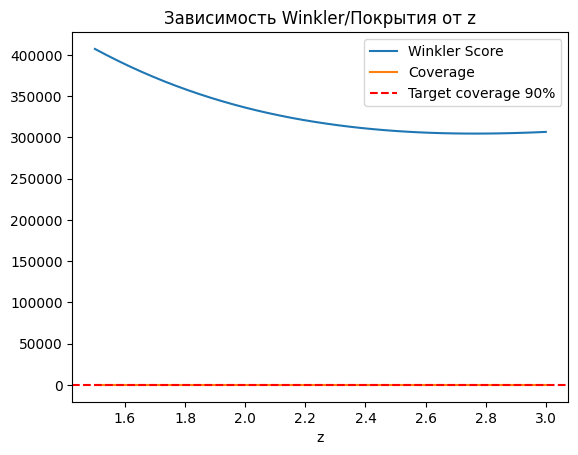

In [140]:
plt.plot(z_values, winklers, label='Winkler Score')
plt.plot(z_values, coverages, label='Coverage')
plt.axhline(0.90, color='red', linestyle='--', label='Target coverage 90%')
plt.legend()
plt.xlabel("z")
plt.title("Зависимость Winkler/Покрытия от z")
plt.show()

## Предсказание на тесте и submit

In [ ]:
mu_test_log    = mean_model.predict(df_test,  num_iteration=mean_model.best_iteration_)

df_test_for_sigma = df_test.copy()
df_test_for_sigma["model_pred"] = mean_model.predict(df_test, num_iteration=mean_model.best_iteration_)
sigma_test_log = sigma_model.predict(df_test_for_sigma, num_iteration=sigma_model.best_iteration_)
sigma_test = np.expm1(sigma_test_log)

z = float(best_z)
submission = pd.DataFrame({
    "id":               df_test.index,
    "pi_lower":  np.expm1(mu_test_log - z * sigma_test),
    "pi_upper":  np.expm1(mu_test_log + z * sigma_test),
})
submission.to_csv("submission.csv", index=False)
print("submission.csv готов! ✅")

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
submission.csv готов! ✅


## Сохранение моделей

In [142]:
mean_model.booster_.save_model("model\mean_model.lgb")
sigma_model.booster_.save_model("model\sigma_model.lgb")